<a href="https://colab.research.google.com/github/mayuravaani/AI/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
        )
        self.mu = nn.Linear(400, latent_dim)
        self.logvar = nn.Linear(400, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar

In [3]:
# Define training settings
latent_dim = 2
batch_size = 128
learning_rate = 0.001

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(datasets.MNIST(root='./data', train=True, transform=transform, download=True), batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 69993133.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22411784.24it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25089120.73it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6897367.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Initialize VAE and optimizer
vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [6]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)

        optimizer.zero_grad()
        reconstructed_data, mu, logvar = vae(data)

        # Calculate reconstruction loss and KL divergence
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_data, data, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.3f}")

Epoch [1/10], Batch [0/469], Loss: 70435.852
Epoch [1/10], Batch [100/469], Loss: 25817.389
Epoch [1/10], Batch [200/469], Loss: 22625.611
Epoch [1/10], Batch [300/469], Loss: 22846.586
Epoch [1/10], Batch [400/469], Loss: 21584.430
Epoch [2/10], Batch [0/469], Loss: 22300.080
Epoch [2/10], Batch [100/469], Loss: 21318.336
Epoch [2/10], Batch [200/469], Loss: 21043.910
Epoch [2/10], Batch [300/469], Loss: 21446.562
Epoch [2/10], Batch [400/469], Loss: 21061.000
Epoch [3/10], Batch [0/469], Loss: 21698.771
Epoch [3/10], Batch [100/469], Loss: 20341.053
Epoch [3/10], Batch [200/469], Loss: 21012.363
Epoch [3/10], Batch [300/469], Loss: 20119.934
Epoch [3/10], Batch [400/469], Loss: 21320.902
Epoch [4/10], Batch [0/469], Loss: 21041.570
Epoch [4/10], Batch [100/469], Loss: 20965.438
Epoch [4/10], Batch [200/469], Loss: 20255.816
Epoch [4/10], Batch [300/469], Loss: 20559.973
Epoch [4/10], Batch [400/469], Loss: 19974.043
Epoch [5/10], Batch [0/469], Loss: 20793.861
Epoch [5/10], Batch [10

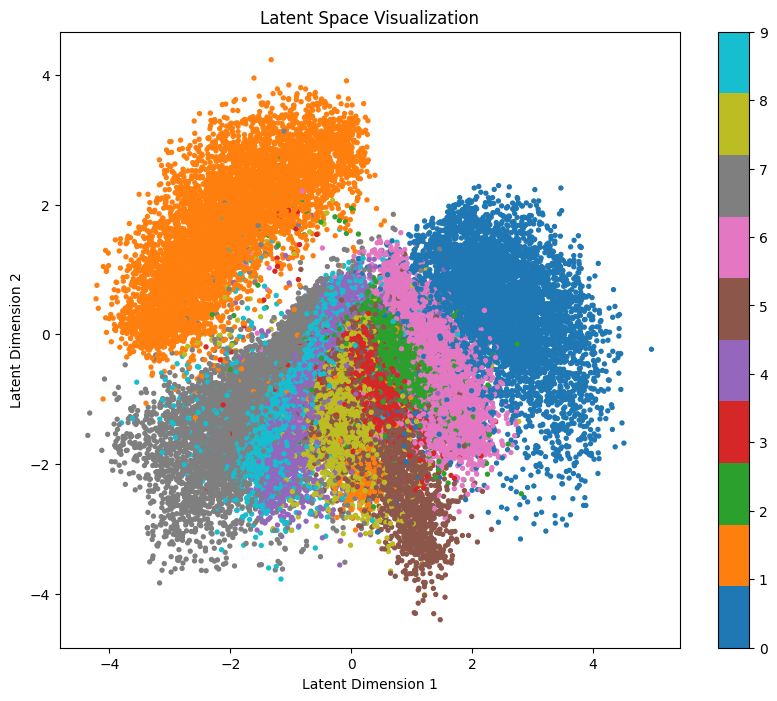

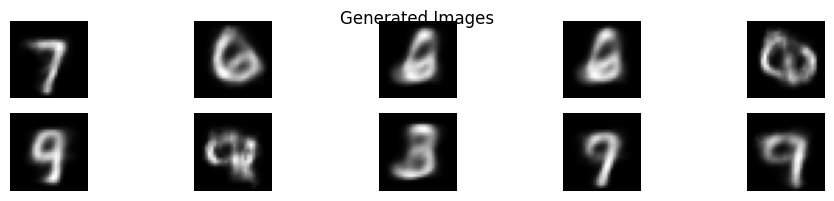

In [7]:
import matplotlib.pyplot as plt


# Visualization of latent space
def visualize_latent_space(vae, dataloader):
    vae.eval()
    with torch.no_grad():
        latent_vectors = []
        labels = []
        for data, target in dataloader:
            data = data.view(-1, 28*28)
            mu, _ = vae.encode(data)
            latent_vectors.append(mu)
            labels.append(target)

        latent_vectors = torch.cat(latent_vectors, dim=0)
        labels = torch.cat(labels, dim=0)

        plt.figure(figsize=(10, 8))
        plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', s=8)
        plt.colorbar()
        plt.title("Latent Space Visualization")
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.show()

# Generating new images
def generate_images(vae, num_samples):
    vae.eval()
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim)
        generated_images = vae.decode(random_latent_vectors)
        generated_images = generated_images.view(-1, 1, 28, 28)

        plt.figure(figsize=(10, 2))
        for i in range(num_samples):
            plt.subplot(2, num_samples//2, i+1)
            plt.imshow(generated_images[i][0], cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.suptitle("Generated Images")
        plt.show()

# ... (Training loop)

# Visualization of latent space after training
visualize_latent_space(vae, train_loader)

# Generate and display new images
num_samples_to_generate = 10
generate_images(vae, num_samples_to_generate)
